# Import Python Libaries

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

plt.rcParams.update({'font.size':20})
import seaborn as sns
%matplotlib inline
import re
import string
import spacy 
import os
import sys
import numpy as np

nlp = spacy.load('en', disable=['ner', 'parser'])
import nltk
from nltk.stem.snowball import SnowballStemmer
from scipy import stats

from time import time
from collections import defaultdict
import gc
import io
import random

from __future__ import print_function, division
from builtins import range
import os
import sys
import numpy as np
import operator

import nltk
nltk.download('all')
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize


import keras
from keras.models import Model, Sequential
from keras.layers import *
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM, Bidirectional, GlobalAveragePooling1D, Dropout, Conv1D, GRU, Layer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam, SGD
from sklearn.metrics import roc_auc_score
import keras.backend as K
from keras.layers import CuDNNLSTM as LSTM
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

from keras import metrics
from tensorflow.python.keras.metrics import Metric
from tensorflow.keras.utils import plot_model

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.utils import shuffle, class_weight
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import cohen_kappa_score, roc_auc_score, f1_score

#from imblearn.over_sampling import RandomOverSampler
#from imblearn.pipeline import Pipeline

from sklearn.pipeline import Pipeline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Package cess_cat is already up-to-date!
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Package cess_esp is already up-to-date!
[nltk_data]    | Downloading packag

Using TensorFlow backend.


In [0]:
# install tensorflow 2.0
#!pip uninstall tensorflow
#!pip install tensorflow-gpu==2.1.0

In [0]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [0]:
# check the availability of GPU
%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


Found GPU at: /device:GPU:0


In [0]:
# Mount Google Drive (to save the downloaded files)
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


### GloVe Pretrained Word Embedding loading

In [0]:
# Load GloVe Embeddings
print('Loading GloVe Embeddings.')

glove_embeddings = {}
f = open('/gdrive/My Drive/glove.42B.300d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    glove_embeddings[word] = coefs
f.close()

print('Found %s word vectors.' % len(glove_embeddings))


Loading GloVe Embeddings.
Found 1917495 word vectors.


# Import cleaned data

In [0]:
data = pd.read_csv('/gdrive/My Drive/cleaned_data.csv', encoding = "ISO-8859-1")

In [0]:
data.head(5)

,Unnamed: 0,_unit_id,positivity,relevance,date,texts
0,0,842613455,3.0,1,8/14/91,yield cd fall late week new york yield cert...
1,1,842613456,NaN,0,8/21/07,morning brief white house seek limit child i...
2,2,842613457,NaN,0,11/14/91,banking bill negotiator set compromise plan...
3,3,842613458,NaN,0,6/16/86,manager journal sniff drug abuser quick fix ...
4,4,842613459,3.0,1,10/4/02,currency trading dollar remain tight range a...


# Text Classification

In [0]:
data = data[['texts','relevance']]

## Oversampling
Oversampling the minority by looking for the synonyms of each word in minor class

In [0]:
# use WordNet to find synonyms of each word and oversample the minor class
from nltk.corpus import wordnet 

def get_synonyms(word):
	synonyms = set()
	for syn in wordnet.synsets(word): 
		for l in syn.lemmas(): 
			synonym = l.name()
			synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
			synonyms.add(synonym) 
	if word in synonyms:
		synonyms.remove(word)
	return list(synonyms)

In [0]:
# minor class data set
df = data[data['relevance']==1]

In [0]:
# function to oversample data
def oversample(wordlist): 
  new_words = wordlist
  for i in range(len(wordlist)):
    for random_word in wordlist[wordlist.index[i]]:
      try:
        synonyms = get_synonyms(random_word)  # find synonyms list of each word
        synonym = random.choice(list(synonyms))  # random select one sysnonym to replace the original word
        new_words[new_words.index[i]] = [synonym if word == random_word else word for word in new_words[new_words.index[i]]]
      except:
        pass
    s = ' '.join(new_words[new_words.index[i]]) # join the list of synonyms to a new sentence
    new_words[new_words.index[i]] = s
  augmented_sentences = pd.DataFrame(columns=['texts','relevance'])
  augmented_sentences['texts'] = new_words
  augmented_sentences['relevance']  = df['relevance']
  return augmented_sentences

In [0]:
# oversample the minor class data twice
sentence = df['texts']
word_list = sentence.str.split()
data_cleaned = data[['texts','relevance']]

random.seed(45)
data_cleaned = data_cleaned.append(oversample(word_list))

random.seed(98)
data_cleaned = data_cleaned.append(oversample(word_list))

In [0]:
dist = data_cleaned.groupby('relevance').count()
dist

,texts
relevance,
0,6571
1,4260


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  import sys


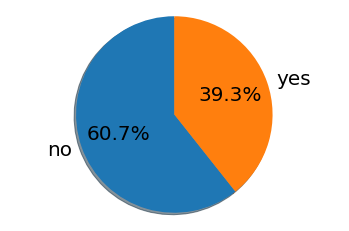

In [0]:
# pie chart of distribution of news relevance
fig1, ax1 = plt.subplots()
sizes = dist.values
label = ['no', 'yes']
plt.rcParams.update({'font.size':20})
ax1.pie(sizes, labels=label, autopct='%1.1f%%',
        shadow=True, startangle=90)
#ax1.set_title('relevance to US economy')
ax1.axis('equal')    
plt.show()

In [0]:
# to ramdom shuffle data
data_cleaned = shuffle(data_cleaned)

In [0]:
# reset data index
data_cleaned = data_cleaned.reset_index()

In [0]:
data_cleaned.head(5)

,index,texts,relevance
0,4728,d washington post consumer product safet...,0
1,6950,fed report disparity area lend black hispa...,1
2,4442,dow rise loss row blue chip stock close mod...,1
3,5034,build freeze lift criticize see today d annu...,0
4,1635,evening wrap supersize vote dozen super tues...,0


## Baselines

### SVM

In [0]:

texts = data_cleaned['texts'].values
labels = data_cleaned['relevance'].values

# Linear SVC Model:
text_clf_lsvc = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', LinearSVC()),
])

# 9-split cross validatioon
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state = 7)

# perform matrix
cvscores_svm = pd.DataFrame(columns = ['tp', 'fp', 'tn', 'fn', 'accuracy','precision', 'recall', 'f1', 'auc', 'cohen_kappa_score'])

for train, test in kfold.split(texts, labels):
# Train both models on the moviereviews.tsv training set:
  text_clf_lsvc.fit(texts[train], labels[train])
  
  predictions_svm = text_clf_lsvc.predict(texts[test])
  predict = [round(value) for value in predictions_svm]
  ck = cohen_kappa_score(labels[test], predict)
  f1 = f1_score(labels[test], predict)
  auc = roc_auc_score(labels[test], predict)

  cm_svm = metrics.confusion_matrix(labels[test], predictions_svm)
  tp = cm_svm[1][1]
  fp = cm_svm[0][1]
  tn = cm_svm[0][0]
  fn = cm_svm[1][0]
  
  cvscores_svm = cvscores_svm.append({'tp': tp, 'fp': fp, 'tn': tn, 'fn': fn, 
                                    'accuracy': (tp + tn)/(tp + fp + tn + fn),
                                    'precision': tp/(tp + fp), 
                                    'recall': tp/((tp + fn)), 
                                    'f1': f1,
                                    'auc': auc,
                                    'cohen_kappa_score': ck
                                    }, 
                                   ignore_index= True)

In [0]:
cvscores_svm

,tp,fp,tn,fn,accuracy,precision,recall,f1,auc,cohen_kappa_score
0,302.0,47.0,611.0,124.0,0.842251,0.865330,0.708920,0.779355,0.818746,0.658474
1,331.0,38.0,619.0,95.0,0.877193,0.897019,0.776995,0.832704,0.859578,0.736480
2,318.0,37.0,620.0,108.0,0.866113,0.895775,0.746479,0.814341,0.845081,0.710994
3,300.0,44.0,613.0,126.0,0.843029,0.872093,0.704225,0.779221,0.818627,0.659574
4,313.0,40.0,617.0,113.0,0.858726,0.886686,0.734742,0.803594,0.836929,0.694790
5,313.0,42.0,615.0,113.0,0.856879,0.881690,0.734742,0.801536,0.835407,0.691063
6,332.0,45.0,612.0,94.0,0.871653,0.880637,0.779343,0.826899,0.855425,0.725520
7,304.0,44.0,613.0,122.0,0.846722,0.873563,0.713615,0.785530,0.823322,0.668151
8,317.0,48.0,609.0,109.0,0.855032,0.868493,0.744131,0.801517,0.835536,0.688401
9,313.0,45.0,612.0,113.0,0.854109,0.874302,0.734742,0.798469,0.833124,0.685485


In [0]:
cvscores_svm.mean()

tp                   314.300000
fp                    43.000000
tn                   614.100000
fn                   111.700000
accuracy               0.857171
precision              0.879559
recall                 0.737793
f1                     0.802317
auc                    0.836178
cohen_kappa_score      0.691893
dtype: float64

In [0]:
cvscores_svm.to_csv("/gdrive/My Drive/svm.csv")

### XGBoost

In [0]:
texts = data_cleaned['texts'].values
labels = data_cleaned['relevance'].values

# XGBoost Model:
text_clf_xgb = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', XGBClassifier()),
])

# 9-split cross validatioon
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state = 7)

# perform matrix
cvscores_xgb = pd.DataFrame(columns = ['tp', 'fp', 'tn', 'fn', 'accuracy','precision', 'recall', 'f1', 'auc', 'cohen_kappa_score'])

for train, test in kfold.split(texts, labels):
  text_clf_xgb.fit(texts[train], labels[train])
  
  predictions_xgb = text_clf_xgb.predict(texts[test])
  predict = [round(value) for value in predictions_xgb]
  ck = cohen_kappa_score(labels[test], predict)
  f1 = f1_score(labels[test], predict)
  auc = roc_auc_score(labels[test], predict)

  cm_xgb = metrics.confusion_matrix(labels[test], predictions_xgb)
  tp = cm_xgb[1][1]
  fp = cm_xgb[0][1]
  tn = cm_xgb[0][0]
  fn = cm_xgb[1][0]
  
  cvscores_xgb = cvscores_xgb.append({'tp': tp, 'fp': fp, 'tn': tn, 'fn': fn, 
                                    'accuracy': (tp + tn)/(tp + fp + tn + fn),
                                    'precision': tp/(tp + fp), 
                                    'recall': tp/((tp + fn)), 
                                     'f1': f1,
                                    'auc': auc,
                                    'cohen_kappa_score': ck
                                    }, 
                                   ignore_index= True)

In [0]:
cvscores_xgb

,tp,fp,tn,fn,accuracy,precision,recall,f1,auc,cohen_kappa_score
0,269.0,4.0,654.0,157.0,0.851476,0.985348,0.631455,0.769671,0.812688,0.667649
1,298.0,2.0,655.0,128.0,0.879963,0.993333,0.699531,0.820937,0.848243,0.734688
2,284.0,3.0,654.0,142.0,0.866113,0.989547,0.666667,0.796634,0.831050,0.702391
3,262.0,3.0,654.0,164.0,0.845799,0.988679,0.615023,0.758321,0.805229,0.653903
4,277.0,3.0,654.0,149.0,0.859649,0.989286,0.650235,0.784703,0.822834,0.687064
5,268.0,1.0,656.0,158.0,0.853186,0.996283,0.629108,0.771223,0.813793,0.671064
6,295.0,3.0,654.0,131.0,0.876270,0.989933,0.692488,0.814917,0.843961,0.726286
7,273.0,5.0,652.0,153.0,0.854109,0.982014,0.640845,0.775568,0.816617,0.674426
8,285.0,5.0,652.0,141.0,0.865189,0.982759,0.669014,0.796089,0.830702,0.700731
9,289.0,4.0,653.0,137.0,0.869806,0.986348,0.678404,0.803894,0.836158,0.711359


In [0]:
cvscores_xgb.mean()

tp                   280.000000
fp                     3.300000
tn                   653.800000
fn                   146.000000
accuracy               0.862156
precision              0.988353
recall                 0.657277
f1                     0.789196
auc                    0.826128
cohen_kappa_score      0.692956
dtype: float64

### Logistic Regression

In [0]:
texts = data_cleaned['texts'].values
labels = data_cleaned['relevance'].values

# Logistic Regression Model:
text_clf_lr = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', LogisticRegression()),
])

# 10-split cross validatioon
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state = 7)

# perform matrix
cvscores_lr = pd.DataFrame(columns = ['tp', 'fp', 'tn', 'fn', 'accuracy','precision', 'recall', 'f1', 'auc', 'cohen_kappa_score'])

for train, test in kfold.split(texts, labels):
  text_clf_lr.fit(texts[train], labels[train])

  predictions_lr = text_clf_lr.predict(texts[test])
  predict = [round(value) for value in predictions_lr]
  ck = cohen_kappa_score(labels[test], predict)
  f1 = f1_score(labels[test], predict)
  auc = roc_auc_score(labels[test], predict)

  cm_lr = metrics.confusion_matrix(labels[test], predictions_lr)
  tp = cm_lr[1][1]
  fp = cm_lr[0][1]
  tn = cm_lr[0][0]
  fn = cm_lr[1][0]
  cvscores_lr = cvscores_lr.append({'tp': tp, 'fp': fp, 'tn': tn, 'fn': fn, 
                                    'accuracy': (tp + tn)/(tp + fp + tn + fn),
                                    'precision': tp/(tp + fp), 
                                    'recall': tp/((tp + fn)), 
                                     'f1': f1,
                                    'auc': auc,
                                    'cohen_kappa_score': ck
                                    }, 
                                   ignore_index= True)

In [0]:
cvscores_lr

,tp,fp,tn,fn,accuracy,precision,recall,f1,auc,cohen_kappa_score
0,292.0,19.0,639.0,134.0,0.858856,0.938907,0.685446,0.792402,0.828285,0.689379
1,314.0,17.0,640.0,112.0,0.880886,0.948640,0.737089,0.829590,0.855607,0.740234
2,302.0,14.0,643.0,124.0,0.872576,0.955696,0.708920,0.814016,0.843806,0.720309
3,279.0,10.0,647.0,147.0,0.855032,0.965398,0.654930,0.780420,0.819854,0.678043
4,296.0,10.0,647.0,130.0,0.870729,0.967320,0.694836,0.808743,0.839807,0.715024
5,296.0,12.0,645.0,130.0,0.868883,0.961039,0.694836,0.806540,0.838285,0.711203
6,316.0,15.0,642.0,110.0,0.884580,0.954683,0.741784,0.834875,0.859476,0.748289
7,293.0,24.0,633.0,133.0,0.855032,0.924290,0.687793,0.788694,0.825632,0.681938
8,305.0,27.0,630.0,121.0,0.863343,0.918675,0.715962,0.804749,0.837433,0.702102
9,306.0,11.0,646.0,120.0,0.879040,0.965300,0.718310,0.823688,0.850784,0.734611


In [0]:
cvscores_lr.mean()

tp                   299.900000
fp                    15.900000
tn                   641.200000
fn                   126.100000
accuracy               0.868896
precision              0.949995
recall                 0.703991
f1                     0.808372
auc                    0.839897
cohen_kappa_score      0.712113
dtype: float64